In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

#Eliminate libraries warnings
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
#Import libraries
import numpy as np

from pylab import rcParams
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from collections import Counter
import statsmodels.api as sm
import statsmodels.tsa as smt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.distributions.empirical_distribution import ECDF

from datetime import date
from datetime import datetime
from datetime import timedelta

#Eliminate libraries warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#read dataframe
rute = '/Users/talitacoll/The Bridge/MMP_Final/'
file = 'data.xlsx'
#Create only the columns used
cols = ['id','order_date']
#Read Excel setting order date as index to be used in our model.
df = pd.read_excel(rute+file,usecols=cols).set_index('order_date').sort_values('id')

**Model works in the general DataSet, but when apply in differents level of data, the model doesn´t work in low frequence situation, for that we have made 2 kind of test, by week and by month.**

* *1 First model we are apply monthly frecuence*

In [ ]:
#Now we know our model works well, we have to create a model for each PN#
itemgroups = []
dfgroupid = df.groupby('id')
for i in df.id.value_counts().index:
    auxdf = dfgroupid.get_group(i).resample('M').count()
    itemgroups.append(auxdf)
    auxdf.to_excel(f'/Users/talitacoll/The Bridge/MMP_Final/tempdatam/{i}.xlsx')

In [3]:
while True:
    answeryes = ['y','Y','Yes','yes','yep','YES','YEp','ye','YE']
    consult=input('Which item would you like to consult?\n')
    c = str.upper(consult)
    if c in (df.id.unique()):
        data = pd.read_excel(f'/Users/talitacoll/The Bridge/MMP_Final/tempdatam/{consult}.xlsx').set_index('order_date')
        obdate =  (datetime.now() - timedelta(days=365))
        frecuence_min = (data[(data.id <1)].value_counts())/len(data)
        if len(data) < 12:
            print(f'No information enough to model a forecast. Would like to see the historical?')
            consult2=input()
            if consult2 in answeryes:
                print(data[data.id>0])
            else:
                print('thanks')
        #elif frecuence_min[0] < 0.09:
         #   print(f'Item {c} has a exporadical frecuence, forecast should be inputed mannually.\n'
          #  'Would like to see the historical?')
           # consult2=input()
            if consult2 in answeryes:
                print(data[data.id>0])
            else:
                print('thanks')
        elif max(data.index) < obdate:
            print(f'Item {c} has not been used on last 12 months, it must be obsolete, please check replacement.')
        
        else:
            print(f'Item {c} is in process, please wait.')
        break
    else:
        print(f'Item {c} is not available, please check the code before consult.')

Which item would you like to consult?
m0a5bb1
Item M0A5BB1 is in process, please wait.


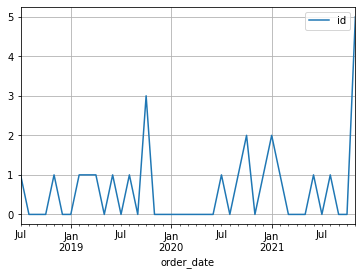

In [4]:
#Plot movement
data.plot();
plt.grid();

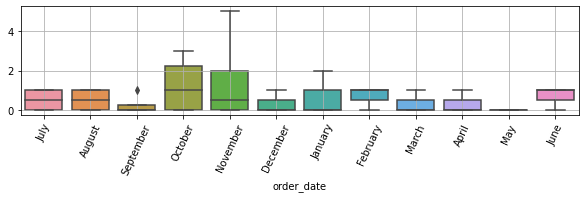

In [5]:
#Plot monthly usage level
_, ax = plt.subplots(figsize=(10,2))
sns.boxplot(x = data.index.month_name(),y = data.values[:,0],ax=ax)
plt.xticks(rotation=65)
plt.grid();

MAPE results:1.9090909390380866


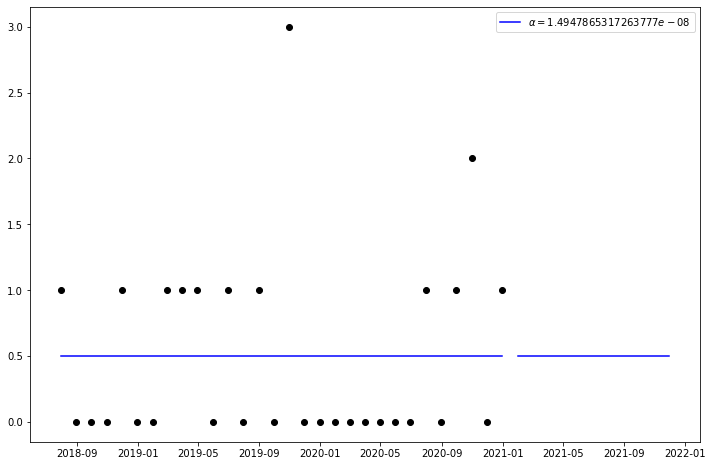

In [40]:
if len(data[data.id>0]) >=24:
    model_arima(data)
else:
    Simple_Exponential_Smoothing(data)

In [47]:
def Simple_Exponential_Smoothing(data):
#train for Smoothing
    tsize = int(len(data)*.80)
    train = data.iloc[:tsize]
    test = data.iloc[tsize:]
    
    def smoothing(data):
    #Simple Exponential Smoothing with alpha optimized.
        fitses = SimpleExpSmoothing(data, initialization_method='estimated').fit(optimized=True)
        fcastses = fitses.forecast(len(test)).rename(r"$\alpha=%s$" % fitses.model.params["smoothing_level"])
        fitholt = Holt(data, initialization_method="estimated").fit(
        smoothing_level=0.9, smoothing_trend=0.2, optimized=False)
        fcastholt = fitholt.forecast(len(test)).rename("Holt's linear trend")
        
        
        plt.figure(figsize=(12, 8))
        plt.plot(data, marker='o', color='black',linestyle = 'None')
        plt.plot(fitses.fittedvalues, color='b')
        (line1,) = plt.plot(fcastses, color='b')
        plt.plot(fitholt.fittedvalues, color='r')
        (line2,) = plt.plot(fcastholt, color='r')
        
        
        
        plt.legend([line1,line2], [fcastses.name,fcastholt.name]);

        #print(fcastses)
        return (fcastses)
    
    #print(mean_squared_error(smoothing(train.values),test))
    print(mean_absolute_percentage_error(smoothing(train),test))
    

1.716049388271269


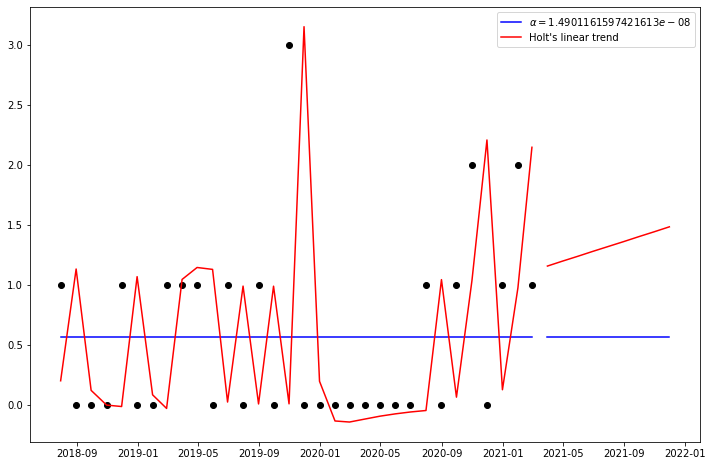

In [48]:
Simple_Exponential_Smoothing(data)

In [ ]:
def model_arima(data):
    
    tsize = int(len(data)*.75)
    train = data.iloc[:tsize]
    test = data.iloc[tsize:]

    #Detecting estationarity
    result = adfuller(train)
    if result[1]<=0.5:
        d=0
    else:
        for i in range(1,3):
            diff = data.diff(i)[i:]
            if adfuller(data.diff().dropna())[1]<0.05:
                d=1
            elif adfuller(data.diff().diff().dropna())[1]<0.05:
                d=2
    #Maximus interations will be the set divided in 12, that means, if the lengt is 36, the system will do 3 iteratios        
    p_max = int(len(data) / 12)
    q_max = int(len(data) / 12)
    matrix_bic = []
    for p in range(p_max +1):
        aux= []
        for q in range(q_max+1):
            try:
                model = ARIMA(data, order=(p,d,q)).fit(disp=False)
                aux.append(model.bic)
            except:
                aux.append(None)
        matrix_bic.append(aux)    
    matrix_bic = pd.DataFrame(matrix_bic)
    #Asigning p and q to matrix in order to find the best(lowest) relation.
    p,q = matrix_bic.stack().astype('float64').idxmin()
    print(matrix_bic)
    print('ARIMA Orders:',p,d,q)
    #Plot a heatmap to identify the best set of orders.
    #The darkest is the section in the grap, the lowest is the order and the best is the correclation
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(matrix_bic,
                 mask=matrix_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
    ax.set_title('BIC');
    
    model=ARIMA(train, order=(0,0,1))
    mfitted = model.fit(disp=0)
    fc, se, conf = mfitted.forecast(12, alpha=0.95)
    fc_series = pd.Series(fc, index=test.index)
    pred = fc_series
    results = pd.DataFrame(test)
    
    results = pd.DataFrame(test)
    results['forecast']=[x for x in list(pred)]
    
    print(results,(f'RMSE:{mean_squared_error(results.forecast,results.id)},MAPE:{mean_absolute_percentage_error(results.forecast,results.id)}'))
    #The darkest is the section in the grap, the lowest is the order and the best is the correclation            
    

 

In [ ]:
model_arima(data)

* *2 First model we are apply weekly frecuence*

In [ ]:
#Now we know our model works well, we have to create a model for each PN#
itemgroups = []
dfgroupid = df.groupby('id')
for i in df.id.value_counts().index:
    auxdf = dfgroupid.get_group(i).resample('W').count()
    itemgroups.append(auxdf)
    auxdf.to_excel(f'/Users/talitacoll/The Bridge/MMP/tempdata/{i}.xlsx')

In [49]:
while True:
    answeryes = ['y','Y','Yes','yes','yep','YES','YEp','ye','YE']
    consult=input('Which item would you like to consult?\n')
    c = str.upper(consult)
    #obdate =  (datetime.now() - timedelta(days=365))
    #frecuence_min = (data[(data.id >1)].value_counts())/len(data)
    #data = pd.read_excel(f'/Users/talitacoll/The Bridge/MMP/tempdata/{consult}.xlsx').set_index('order_date')
    if c in (df.id.unique()):
        data = pd.read_excel(f'/Users/talitacoll/The Bridge/MMP/tempdata/{consult}.xlsx').set_index('order_date')
        obdate =  (datetime.now() - timedelta(days=365))
        frecuence_min = (data[(data.id <1)].value_counts())/len(data)
        if len(data) < 60:
            print(f'No information enough to model a forecast. Would like to see the historical?')
            consult2=input()
            if consult2 in answeryes:
                print(data[data.id>0])
            else:
                print('thanks')
        #elif frecuence_min[0] > 0.09:
         #   print(f'Item {c} has a exporadical frecuence, forecast should be inputed mannually.\n'
          #  'Would like to see the historical?')
           # consult2=input()
            if consult2 in answeryes:
                print(data[data.id>0])
            else:
                print('thanks')
        elif max(data.index) < obdate:
            print(f'Item {c} has not been used on last 12 months, it must be obsolete, please check replacement.')
        
        else:
            print(f'Item {c} is in process, please wait.')
        break
    else:
        print(f'Item {c} is not available, please check the code before consult.')

Which item would you like to consult?
m0a5bb1
Item M0A5BB1 is in process, please wait.


2.1176471567849737


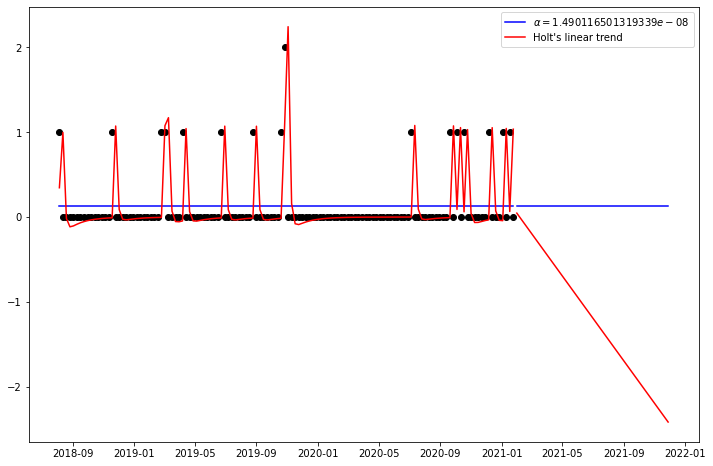

In [54]:
if len(data[data.id>0]) >=60:
    model_arimaW(data)
else:
    Simple_Exponential_SmoothingW(data)

In [ ]:
len(data)

In [ ]:
#Plot movement
data.plot();
plt.grid();

In [ ]:
#Plot monthly usage level
_, ax = plt.subplots(figsize=(10,2))
sns.boxplot(x = data.index.month_name(),y = data.values[:,0],ax=ax)
plt.xticks(rotation=65)
plt.grid();

In [53]:
def Simple_Exponential_SmoothingW(data):
#train for Smoothing
    tsize = int(len(data)*.75)#For weekly test we change the proportions for train and test
    train = data.iloc[:tsize]
    test = data.iloc[tsize:]
    
    def smoothing(data):
    #Simple Exponential Smoothing with alpha optimized.
        fitses = SimpleExpSmoothing(data, initialization_method='estimated').fit(optimized=True)
        fcastses = fitses.forecast(len(test)).rename(r"$\alpha=%s$" % fitses.model.params["smoothing_level"])
        fitholt = Holt(data, initialization_method="estimated").fit(
        smoothing_level=0.9, smoothing_trend=0.2, optimized=False)
        fcastholt = fitholt.forecast(len(test)).rename("Holt's linear trend")
        
        
        plt.figure(figsize=(12, 8))
        plt.plot(data, marker='o', color='black',linestyle = 'None')
        plt.plot(fitses.fittedvalues, color='b')
        (line1,) = plt.plot(fcastses, color='b')
        plt.plot(fitholt.fittedvalues, color='r')
        (line2,) = plt.plot(fcastholt, color='r')
        
        
        
        plt.legend([line1,line2], [fcastses.name,fcastholt.name]);

        return (fcastses)
    
    #print(mean_squared_error(smoothing(train.values),test))
    print(mean_absolute_percentage_error(smoothing(train),test))

In [51]:
def model_arimaW(data):
    
    tsize = int(len(data)*.75)
    train = data.iloc[:tsize]
    test = data.iloc[tsize:]

    #Detecting estationarity
    result = adfuller(train)
    if result[1]<=0.5:
        d=0
    else:
        for i in range(1,3):
            diff = data.diff(i)[i:]
            if adfuller(data.diff().dropna())[1]<0.05:
                d=1
            elif adfuller(data.diff().diff().dropna())[1]<0.05:
                d=2
    #Maximus interations will be the set divided in 52.
    p_max = int(len(data) / 52)
    q_max = int(len(data) / 52)
    matrix_bic = []
    for p in range(p_max +1):
        aux= []
        for q in range(q_max+1):
            try:
                model = ARIMA(data, order=(p,d,q)).fit(disp=False)
                aux.append(model.bic)
            except:
                aux.append(None)
        matrix_bic.append(aux)    
    matrix_bic = pd.DataFrame(matrix_bic)
    #Asigning p and q to matrix in order to find the best(lowest) relation.
    p,q = matrix_bic.stack().astype('float64').idxmin()
    print(matrix_bic)
    print('ARIMA Orders:',p,d,q)
    #Plot a heatmap to identify the best set of orders.
    #The darkest is the section in the grap, the lowest is the order and the best is the correclation
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(matrix_bic,
                 mask=matrix_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
    ax.set_title('BIC');
    
    model=ARIMA(train, order=(0,0,1))
    mfitted = model.fit(disp=0)
    fc, se, conf = mfitted.forecast(len(test), alpha=0.95)
    fc_series = pd.Series(fc, index=test.index)
    pred = fc_series
    results = pd.DataFrame(test)
    
    results = pd.DataFrame(test)
    results['forecast']=[x for x in list(pred)]
    
    print(f'RMSE:{mean_squared_error(results.forecast,results.id)},MAPE:{mean_absolute_percentage_error(results.forecast,results.id)}')
    #The darkest is the section in the grap, the lowest is the order and the best is the correclation            

# Final Conclusion

- Model only works for high data volumn, analysing id by id, the have to be replanned.